# **Movie Recommendation System Part 1**


-----------------
## **Objective**
-----------------

In this case study, I will build various recommendation systems: 
- Knowledge/Rank based recommendation system
- Similarity-Based Collaborative filtering
- Matrix Factorization Based Collaborative Filtering

To demonstrate the above techniques, I am going to use the **ratings** dataset. 

-----------------
## **Dataset**
-----------------

The **ratings** dataset contains the following attributes: 
- userId
- movieId
- rating
- timestamp

## **Importing the necessary libraries and overview of the dataset**

In [1]:
import warnings                                 
warnings.filterwarnings('ignore')

import numpy as np                              
import pandas as pd

import matplotlib.pyplot as plt                 
import seaborn as sns                           

from collections import defaultdict             

from sklearn.metrics import mean_squared_error 

### **Loading the data**

In [3]:
# Importing the "ratings.csv" dataset
rating = pd.read_csv('/Users/yuchenzhou/Desktop/MIT/recommendationProject/ratings.csv')

Let's check the **info** of the data.

In [4]:
# Info of the dataframe
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- In the ratings data, there are **100,836 rows** and **4 columns**.
- All the columns are of **numeric data type**.
- The data type of the timestamp column is int64 which is incorrect.  **I don't need a timestamp column for our analysis**. 

In [5]:
rating = rating.drop(['timestamp'], axis = 1)

In [6]:
rating.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## **Exploring the dataset**


In [7]:
# Finding number of unique users 
rating['userId'].nunique()

610

- There are **610 unique users** in the "rating" dataset.

In [8]:
# Finding the number of unique movies
rating['movieId'].nunique()


9724

- There are **9,724 unique movies** in the dataset.
- As per the number of unique users and movies, there is a **possibility of 610 * 9724 = 59,31,640 ratings** in the dataset. But **we only have 100,836 ratings**, i.e., not every user has rated every movie in the dataset, which is quite understandable. This creates the possibility of building a recommendation system to recommend movies to the users which they have not interacted with.

#### **Q: Is there any movie that has been interacted with more than once by the same user?**

In [9]:
# Finding the frequency of movies rated by each user
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      1             1
       3             1
       6             1
       47            1
       50            1
...                ...
610    166534        1
       168248        1
       168250        1
       168252        1
       170875        1

[100836 rows x 1 columns]

In [10]:
# Finding the sum of ratings count 
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100836

- The **sum is equal to the total number of observations**, which implies that **there is only one interaction between a pair of a movie and a user**.

#### **Q: Which one is the most interacted movie in the dataset?**

In [11]:
# Counting the number of people who have watched a certain movie
rating['movieId'].value_counts()

356       329
318       317
296       307
593       279
2571      278
         ... 
5986        1
100304      1
34800       1
83976       1
8196        1
Name: movieId, Length: 9724, dtype: int64

- The **movie with movieId 356 has been interacted by most users** which is **329** times.
- But still, there is a possibility of 610-329 = 281 more interactions as we have 610 unique users in our dataset. For those 281 remaining users, we can build a recommendation system to predict who is most likely to interact with this movie.

Also, out of these 329 interactions, we should consider the distribution of ratings as well to check whether this movie is the most liked or most disliked movie.

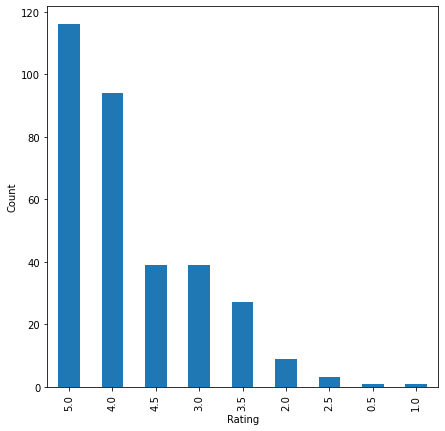

In [12]:
# Plotting distributions of ratings for 329 interactions with movieid 356

plt.figure(figsize = (7, 7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind = 'bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

- We can see that **this movie has been liked by the majority of users**, as the count of ratings 5 and 4 is higher than the count of lower ratings. 
- There can be movies with very high interactions but the count of ratings 1 and 2 may be much higher than the count for ratings 4 or 5 which would imply that the movie is disliked by the majority of the users.

#### **Q: Which user interacted the most with any movie in the dataset?**

In [13]:
rating['userId'].value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: userId, Length: 610, dtype: int64

- The user with **userId: 414** has interacted with the most number of movies, i.e., **2,698** times. 
- But still, there is a possibility of 9724 - 2698 = 7026 more interactions as we have 9724 unique movies in our dataset. For those **7026** remaining movies, we can build a recommendation system to predict which movies are most likely to be watched by this user.

#### **Q: What is the distribution of the user-movie interactions in this dataset?**

In [14]:
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: movieId, Length: 610, dtype: int64

## **Rank Based Recommendation System**

In [15]:
average_rating = rating.groupby('movieId').mean()['rating']

count_rating = rating.groupby('movieId').count()['rating']

final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

In [16]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.920930,215
2,3.431818,110
3,3.259615,52
4,2.357143,7
5,3.071429,49


create a function to find the **top n movies** for a recommendation based on the average ratings of movies. 

also add a **threshold for a minimum number of interactions** for a movie to be considered for recommendation. 

In [17]:
# It gives top n movies among those being watched for more than min_interactions
def top_n_movies(data, n, min_interaction = 100):
    
    # Finding movies with interactions greater than the minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    # Sorting values with respect to the average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get movies to be recommended.

### **Recommending top 5 movies with 50 minimum interactions based on popularity**

In [18]:
list(top_n_movies(final_rating, 5, 50))

[318, 858, 2959, 1276, 750]

### **Recommending top 5 movies with 100 minimum interactions based on popularity**

In [19]:
list(top_n_movies(final_rating, 5, 100))

[318, 858, 2959, 1221, 48516]

### **Recommending top 5 movies with 200 minimum interactions based on popularity**

In [20]:
list(top_n_movies(final_rating, 5, 200))

[318, 2959, 50, 260, 527]

Now that we have seen **how to apply the Rank-Based Recommendation System**, let's apply the **Collaborative Filtering Based Recommendation Systems**.

### **Building a baseline user-user similarity based recommendation system**

In [22]:
from surprise import accuracy

# Class to parse a file containing ratings, data should be in structure - user; item; rating
from surprise.reader import Reader

from surprise.dataset import Dataset

# model tuing
from surprise.model_selection import GridSearchCV

from surprise.model_selection import train_test_split

#  similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

#  matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# K-Fold cross-validation
from surprise.model_selection import KFold

# clustering-based recommendation system
from surprise import CoClustering

### **function to take recommendation model as input and gives the precision@k, recall@k, and F1-score@k for that model.** 

In [23]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    #  map the predictions to each user
    user_est_true = defaultdict(list)
    
    # predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

    

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
 
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) 
    
    print('Recall: ', recall) 
    
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) 

In [24]:
reader = Reader(rating_scale = (0, 5))

data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

### using  **KNNBasic** to find the **desired similar items among a given set of items**.

In [25]:
sim_options = {'name': 'cosine',
               'user_based': True}

sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

sim_user_user.fit(trainset)

precision_recall_at_k(sim_user_user)

RMSE: 0.9823
Precision:  0.757
Recall:  0.542
F_1 score:  0.632


- Recall: We are getting a **recall of ~0.54**, which means out of **all the relevant movies 54% are recommended**. 
- Precision: We are getting a **precision of ~ 0.76**, which means **out of all the recommended movies 76% are relevant**.
- **F_1 score** of the **baseline model is ~0.63**. It indicates that **mostly recommended movies were relevant and relevant movies were recommended**. I will try to improve this later by using **GridSearchCV by tuning different hyperparameters** of this algorithm.

**predict the rating for the user with `userId = 4` and the movie with `movieId = 10`** as shown below. Here, the user has already interacted or watched the movie with movieId 10.

In [26]:
sim_user_user.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.41   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.4133289774831344, details={'actual_k': 40, 'was_impossible': False})

- The above output shows that **the actual rating is not so far from the predicted rating for this user-item pair** by this **user-user-similarity-based baseline model**.
- The **output** also contains **"actual_k"**. It is the value of **K in KNN** that is used while training the model. The default value is 40.

Below is the **list of users who have seen the movie with movieId 3**.

In [27]:
rating[rating.movieId == 3].userId.unique()

array([  1,   6,  19,  32,  42,  43,  44,  51,  58,  64,  68,  91, 100,
       102, 116, 117, 150, 151, 169, 179, 217, 226, 240, 269, 270, 288,
       289, 294, 302, 307, 308, 321, 330, 337, 368, 410, 414, 448, 456,
       470, 477, 480, 492, 501, 544, 552, 555, 588, 590, 594, 599, 608])

* As the above list does not contain user id 4, we can say that **user with user id 4 has not seen the movie with movieId 3**.

Below, we are **predicting the rating for the same `userId = 4` but for a movie with which this user has not interacted yet, i.e., `movieId = 3`**. 

In [28]:
sim_user_user.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.26   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.260929007645626, details={'actual_k': 40, 'was_impossible': False})

Above, we have **predicted the rating for this user-item pair** based on this user-user similarity-based baseline model.

### **Improving similarity-based recommendation system (hyperparameter tuning)**

In [29]:
param_grid = {'k': [30, 40, 50], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

gs.fit(data)

print(gs.best_score['rmse'])

print(gs.best_params['rmse'])

0.9496274022139369
{'k': 30, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


In [30]:

sim_options = {'name': 'msd',
               'user_based': True}


sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 3, random_state = 1, verbose = False)


sim_user_user_optimized.fit(trainset)

precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9467
Precision:  0.762
Recall:  0.554
F_1 score:  0.642


- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model has increased slightly, from 0.632 to 0.642**. 
- **The RMSE of the model has gone down as compared to the model before hyperparameter tuning**. Hence, we can say that the model performance has improved slightly after hyperparameter tuning.

now I can **predict the rating for the user with `userId = 4` and the movie with `movieId = 10` with the optimized model as shown below**.

In [31]:
sim_user_user_optimized.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.50   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.497691535784751, details={'actual_k': 30, 'was_impossible': False})

- when comparing the predicted rating with the actual raring, we can conclude that the **predicted rating by the tuned model is closer to the actual rating in comparison to the prediction by the baseline model**.

Now predicting the rating for the same **`userId = 4`** but for a movie with which this user has **not interacted before**, i.e., `movieId = 3`, by using the **optimized model**.

In [32]:
sim_user_user_optimized.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.45   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.4530529132024763, details={'actual_k': 30, 'was_impossible': False})

### **Identifying similar users to a given user (nearest neighbors)**

find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. 
Below, I am finding **the 5 most similar users to `userId = 4`** based on the **`msd` distance metric**.

In [33]:
sim_user_user_optimized.get_neighbors(4, k = 5)

[89, 90, 91, 181, 230]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

In [34]:
def get_recommendations(data, user_id, top_n, algo):

    recommendations = []
    
    user_item_interactions_matrix = data.pivot(index = 'userId', columns = 'movieId', values = 'rating')
    
    # Extracting those movie IDs which the user ID has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the movie IDs which user ID has not interacted yet
    for item_id in non_interacted_movies:
        
        # Predicting the ratings for those non interacted movie IDs by this user
        est = algo.predict(user_id, item_id).est
        
        recommendations.append((item_id, est))

    recommendations.sort(key = lambda x: x[1], reverse = True)

    # Return top n highest predicted rating movies 
    return recommendations[:top_n]

#### **Predicted top 5 movies for userId = 4 using the similarity-based recommendation system.**

In [35]:
recommendations = get_recommendations(rating, 4, 5, sim_user_user_optimized)

In [36]:
pd.DataFrame(recommendations, columns = ['movieId', 'predicted_ratings'])

,movieId,predicted_ratings
0,3404,5.000000
1,7121,5.000000
2,6460,4.844207
3,115122,4.813285
4,1178,4.808807


### **Correcting the Ratings and Ranking the above movies**

While comparing the ratings of two movies, it is not only the **ratings** that describe the **likelihood of the user to interact with that movie**. Along with the rating, the **number of users who have watched that movie** also become important to consider. Due to this, we have calculated the **"corrected_ratings"** for each movie. 

Generally, higher the **"rating_count" of a movie, more reliable the rating is**. To interpret the above concept, a **movie rated 4 with rating_count 3 is less liked in comparison to a movie rated 3 with a rating count of 50**. It has been **empirically found that the likelihood of the movie is directly proportional to the inverse of the square root of the rating_count of the movie**.

In [37]:
def ranking_movies(recommendations, final_rating):

  # Sort the movies based on ratings count
  ranked_movies = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending = False)[['rating_count']].reset_index()

  # Merge with the recommended movies to get predicted ratings
  ranked_movies = ranked_movies.merge(pd.DataFrame(recommendations, columns = ['movieId', 'predicted_ratings']), on = 'movieId', how = 'inner')

  # Rank the movies based on corrected ratings
  ranked_movies['corrected_ratings'] = ranked_movies['predicted_ratings'] - 1 / np.sqrt(ranked_movies['rating_count'])

  # Sort the movies based on corrected ratings
  ranked_movies = ranked_movies.sort_values('corrected_ratings', ascending = False)
  
  return ranked_movies

In [38]:
ranking_movies(recommendations, final_rating)

,movieId,rating_count,predicted_ratings,corrected_ratings
1,3404,6,5.000000,4.591752
0,1178,12,4.808807,4.520132
3,7121,4,5.000000,4.500000
2,6460,5,4.844207,4.396993
4,115122,3,4.813285,4.235934


### **Item-Item Similarity-Based Collaborative Filtering Recommendation Systems**

look into similarity-based collaborative filtering where similarity is computed **between items**. 

In [39]:
sim_options = {'name': 'cosine',
               'user_based': False}

sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

sim_item_item.fit(trainset)
precision_recall_at_k(sim_item_item)

RMSE: 0.9800
Precision:  0.609
Recall:  0.464
F_1 score:  0.527


-  **F_1 score** of the **baseline model** is **~0.53**. We can improve this later by tuning different hyperparameters of this algorithm using **GridSearchCV**.

**predict the rating for the user with `userId = 4` and the movie with `movieId = 10`** as shown below. Here, the user has already interacted or watched the movie with movieId 10.

In [40]:
sim_item_item.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.63   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6257369831511945, details={'actual_k': 40, 'was_impossible': False})

- The above output shows that **the actual rating for this user-item pair is 4, and the predicted rating is close to that**.

**predict the rating for the same `userId = 4` but for a movie with which this user has not interacted yet, i.e., `movieId = 3`**. 

In [41]:
sim_item_item.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.67   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.6748659322681623, details={'actual_k': 40, 'was_impossible': False})

### **Improving similarity-based recommendation system by tuning its hyperparameters**

In [42]:
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.917138528416429
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


In [43]:
sim_options = {'name': 'msd',
               'user_based': False}

sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 1, verbose = False)

sim_item_item_optimized.fit(trainset)

precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9160
Precision:  0.678
Recall:  0.499
F_1 score:  0.575


- We can observe that after tuning hyperparameters, **F_1 score of the model is better than the baseline model**. 
- **the RMSE of the model has gone down in comparison to the model with default hyperparameters**. Hence, we can say that the model performance has improved after hyperparameter tuning.

now predict the **rating for the user with `userId = 4` and the movie with `movieId = 10`** 

In [44]:
sim_item_item_optimized.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.26   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.2569148418342952, details={'actual_k': 30, 'was_impossible': False})

- We observe that the predicted rating by the baseline model was closer to the actual rating in comparison to that by the optimized model. This might be because, although the overall score has increased, the prediction for this particular user is not that good.

**predict the rating** for the same **`userId = 4`** but for a movie which this user **has not interacted before**, i.e., `movieId = 3`

In [45]:
sim_item_item_optimized.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.57   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.574650247164053, details={'actual_k': 30, 'was_impossible': False})

### **Identifying similar items to a given item (nearest neighbors)**

**KNNBasic algorithm**. Below, I am finding the 5 most similar users to `userId = 4` based on the `msd` distance metric.

In [46]:
sim_item_item_optimized.get_neighbors(4, k = 5)

[45, 73, 148, 155, 180]

#### **Predicting top 5 movies for userId = 4 using the similarity-based recommendation system.**

In [47]:
recommendations = get_recommendations(rating, 4, 5, sim_item_item_optimized)

In [48]:
pd.DataFrame(recommendations, columns = ['movieId', 'predicted_ratings'])

,movieId,predicted_ratings
0,5706,4.771028
1,176579,4.748016
2,25959,4.744049
3,2149,4.730439
4,56176,4.724374


In [49]:
ranking_movies(recommendations, final_rating)

,movieId,rating_count,predicted_ratings,corrected_ratings
0,2149,4,4.730439,4.230439
1,56176,3,4.724374,4.147023
2,5706,1,4.771028,3.771028
3,176579,1,4.748016,3.748016
4,25959,1,4.744049,3.744049


As **similarity-based collaborative filtering algorithms** has been explored,
the next is to explore **model-based collaborative filtering algorithm**.

## **Model Based Collaborative Filtering - Matrix Factorization**

### **Building a baseline matrix factorization recommendation system**

In [50]:
svd = SVD(random_state = 1)

svd.fit(trainset)

precision_recall_at_k(svd)

RMSE: 0.8797
Precision:  0.738
Recall:  0.507
F_1 score:  0.601


- We can observe that the **F_1 score** for the matrix factorization model on the test set is lower in comparison to the F_1 score for the user-user-similarity recommendation system and optimized user-user similarity-based recommendation system.

Let's now predict the rating for the user with **`userId = 4`** and the movie with **`movieId = 10`** as shown below. Here, the user has already rated the movie.

In [52]:
# Making prediction for userId 4 and movieId 10
svd.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.33   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.333359479354037, details={'was_impossible': False})

- The actual rating for this user-item pair is 4 and the predicted rating is far from the same. It seems that the model has under-estimated the rating. We will try to fix this by **tuning the hyperparameters** of the model using GridSearchCV.

Below, we are predicting rating for the same `userId = 4` but for a movie which this user has not interacted before, i.e., `movieId = 3`, as shown below. 

In [53]:
# Making prediction for userid 4 and movieId 3
svd.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 2.94   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=2.9386110726567756, details={'was_impossible': False})

### **Improving matrix factorization based recommendation system by tuning its hyperparameters**

In [54]:
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

gs.fit(data)

print(gs.best_score['rmse'])

print(gs.best_params['rmse'])

0.8728239048785712
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters as shown above.

In [55]:
svd_optimized = SVD(n_epochs = 30, lr_all = 0.01, reg_all = 0.2, random_state = 1)

svd_optimized = svd_optimized.fit(trainset)

precision_recall_at_k(svd_optimized)

RMSE: 0.8752
Precision:  0.731
Recall:  0.511
F_1 score:  0.602


predict the rating for the user with `userId = 4` and the movie with `movieId = 10` with the optimized model

In [56]:
svd_optimized.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.39   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.3892642624049993, details={'was_impossible': False})

In [57]:
svd_optimized.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.20   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.20286300753659, details={'was_impossible': False})

**Now, recommend the movies using the optimized svd model.**

In [58]:
svd_recommendations = get_recommendations(rating, 4, 5, svd_optimized)

In [59]:
ranking_movies(svd_recommendations, final_rating)

,movieId,rating_count,predicted_ratings,corrected_ratings
0,1178,12,4.446400,4.157725
1,177593,8,4.380428,4.026875
2,106642,7,4.379596,4.001631
3,3266,6,4.332485,3.924236
4,7121,4,4.342665,3.842665


## **Conclusion**

In this case study, I built recommendation systems using four different algorithms. They are as follows:
  - Rank-based using averages
  - User-User similarity-based collaborative filtering
  - Item-Item similarity-based collaborative filtering
  - Model-based collaborative filtering (matrix factorization)

- The **surprise** library was used to demonstrate**"user-user similarity-based collaborative filtering," "item-item similarity-based collaborative filtering," and "model-based collaborative filtering (matrix factorization)"** algorithms. For these algorithms, grid search cross-validation is used to find the optimal hyperparameters for the data, and related predictions are created using the optimal hyperparameters.
- **For performance evaluation** of these models **precision@k and recall@k** are used. Using these two metrics, the **F_1 score** is calculated for each working model. 
- Overall, the user-user similarity-based recommendation system has given the best performance in terms of the F1-Score.
- We can try to further improve the performance of these models using hyperparameter tuning. 
- We can also combine different recommendation techniques to build hybrid recommendation systems.